In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from Functions import cleanFunctions as cf
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Grabbing per game data for players in the 90s
year = np.arange(1990, 2020, 1)
url1 = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
url2 = "https://www.basketball-reference.com/leagues/NBA_{}_per_minute.html"
url3 = "https://www.basketball-reference.com/leagues/NBA_{}_per_poss.html"
url4 = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html"
urls = np.array([url1, url2, url3, url4])
stats_year = pd.DataFrame()
stats = pd.DataFrame()
count = 0
for y in year:
    for u in urls:
        print("Progress {:2.1%}".format(count / (len(year)*len(urls))), end="\r")#print progress of paint can position acquisition
        # URL page we will scraping (see image above)
        url = u.format(y)

        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html)

        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers
        
        #when concatenating data from each BR page, some duplicate columns are kept, and some columns need
        #to have additional info attached to their labels in order to know that they refer to per 36 or per poss
        #statistics and not per game statistics. The following conditional fix these flaws in the header labels
        if "per_game" in u:
            mystring = "_pg"
            dup = ['Player','Pos','Age','Tm','Year','G','GS']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_minute" in u:
            mystring = "_pm"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_poss" in u:
            mystring = "_pp"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring

        # avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]


        stats_new = pd.DataFrame(player_stats, columns = headers)
        if "per_game" not in u:
            stats_new.drop(['Pos', 'Age', 'Tm', 'G'], axis=1)
        [p, s] = stats_new.shape

        stats_year = pd.concat([stats_year, stats_new], axis=1, sort=False)
        count = count + 1
    stats_year.insert (4, "Year", (y*np.ones((p, 1))).astype(int))
    stats = stats.append(stats_year, ignore_index=True)
    stats_year = pd.DataFrame()


stats = stats.drop(['_pp', '\xa0', '\xa0', 'MP_pp', 'MP_pm', 'GS_pp', 'GS_pm'], axis=1)
stats = stats.loc[:,~stats.columns.duplicated()]
stats = stats[~stats['Player'].isnull()]#drop instances where player name is null
stats.head(10)

,Player,Pos,Age,Tm,Year,G,GS,MP_pg,FG_pg,FGA_pg,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Mark Acres,C,27,ORL,1990,80,50,21.1,1.7,3.6,...,17.2,9.4,1.1,0.6,1.6,.047,-3.1,-0.6,-3.7,-0.7
1,Michael Adams,PG,27,DEN,1990,79,74,34.1,5.0,12.5,...,11.1,18.5,4.4,2.5,6.9,.124,1.8,-0.1,1.8,2.6
2,Mark Aguirre,SF,30,DET,1990,78,40,25.7,5.6,11.5,...,10.7,24.3,3.1,2.5,5.7,.136,1.0,0.0,1.0,1.5
3,Danny Ainge,PG,30,SAC,1990,75,68,36.4,6.7,15.4,...,12.7,23.0,2.7,2.1,4.8,.085,1.2,-0.1,1.1,2.1
4,Mark Alarie,PF,26,WSB,1990,82,10,23.1,4.5,9.6,...,10.7,20.4,1.5,1.6,3.1,.079,-0.6,-0.7,-1.3,0.3
5,Steve Alford,PG,25,DAL,1990,41,0,7.4,1.5,3.4,...,9.4,24.7,0.6,0.3,0.9,.144,1.2,0.4,1.6,0.3
6,Randy Allen,SG,25,SAC,1990,63,6,11.8,1.7,3.8,...,9.8,16.5,-0.3,0.6,0.2,.014,-4.2,-0.9,-5.2,-0.6
7,Greg Anderson,PF,25,MIL,1990,60,28,21.5,3.7,7.2,...,13.6,19.1,0.2,1.7,2.0,.073,-2.8,-0.9,-3.8,-0.6
8,Nick Anderson,SG,22,ORL,1990,81,9,22.0,4.6,9.3,...,13.7,22.1,1.2,0.7,1.8,.049,0.0,-1.0,-1.0,0.5
9,Richard Anderson,PF,29,CHH,1990,54,2,11.2,1.6,3.9,...,10.5,17.4,0.4,0.5,1.0,.077,0.6,0.2,0.7,0.4


In [3]:
#stats.loc[stats['Player'] == 'Kobe Bryant']#example player data

In [24]:
#data preprocessing
stats.insert(5, 'Decade', stats.loc[:,'Year']%100 // 10)

#for columns known to be numeric, cast to numeric quantities
for c in stats.loc[:, 'Year':].columns.tolist():
    stats.loc[:, c] = pd.to_numeric(stats.loc[:, c])

stats_filt = stats[stats["G"] >= 20]#filter out players who played less than 20 games

#get list of categories in the filtered data set that have null entries after casting to numeric
nulls = [i for i, e in enumerate(stats_filt.isnull().sum().tolist()) if e != 0]
cols = stats_filt.columns.tolist()
null_cats = [cols[i] for i in nulls]

#entries of the filtered dataframe may be null after casting to numeric. check what these specific
#categories describe, in this case the null cats are shooting percentages which likely
#means that a given player did not attempt shots of that type and therfore had a non-numeric (i.e empty)
#string value for their shooting percentage. These instances can be safely imputed as 0.
stats_filt = stats_filt.fillna(0)

#standardize position categories, in the case of multi position players... assign them as their primary position
pos_col = stats_filt.loc[:, 'Pos'].tolist()
for i in range(0, len(pos_col)):
    pos = pos_col[i].split('-')
    pos_col[i] = pos[0]

stats_filt.loc[:, 'Pos'] = pos_col

print(stats.shape)#shape of original data set
print(stats_filt.shape)#shape after filtering on games played

ValueError: cannot insert Decade, already exists

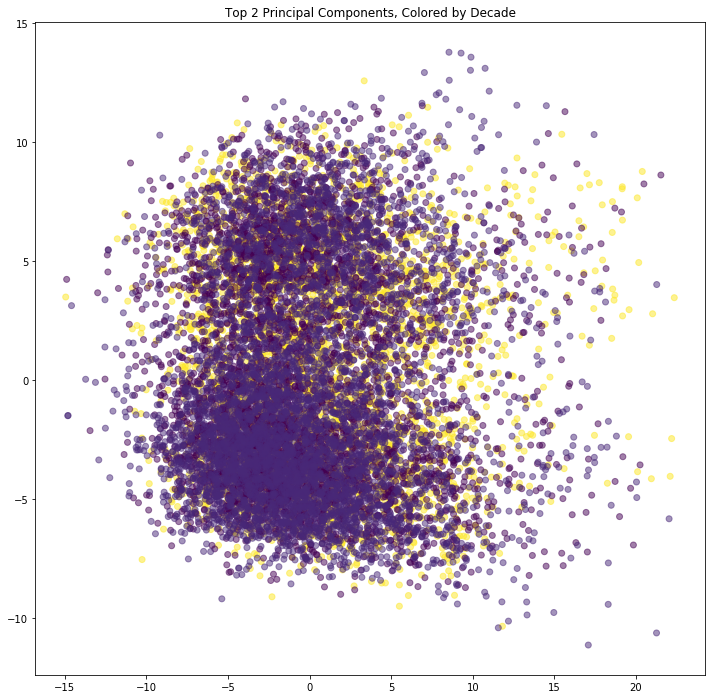

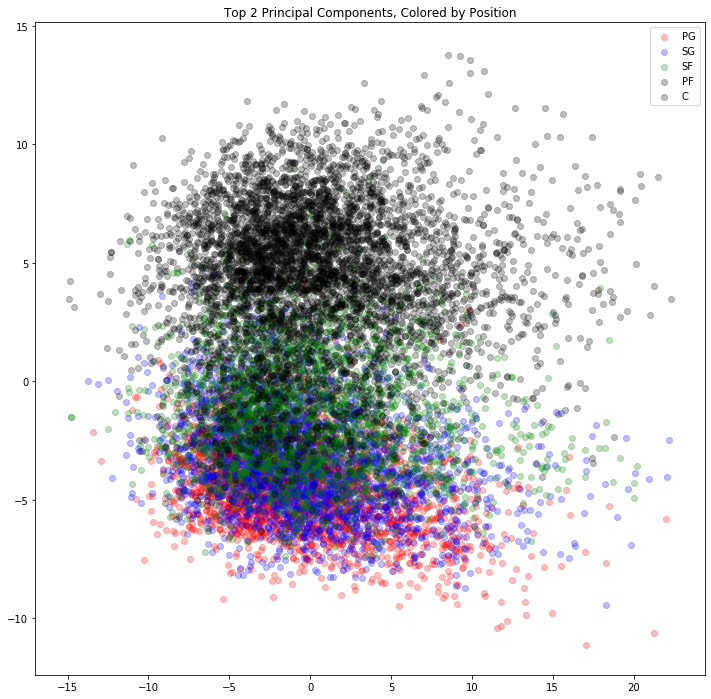

In [50]:
#standardize data before PCA
X = StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':])

#perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pDf_1 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pDf_1['Decade']  = stats_filt['Decade'].tolist()
pDf_1['Pos'] = stats_filt['Pos'].tolist()

#first plot colored by decade
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(pDf_1.loc[:,"PC1"], pDf_1.loc[:,"PC2"], alpha=0.5, c=pDf_1.loc[:,'Decade'])
ax.set_title("Top 2 Principal Components, Colored by Decade")

#second plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'black'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_1.index[pDf_1['Pos'] == g]
    ax.scatter(pDf_1.loc[ix, "PC1"], pDf_1.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position")
ax.legend()
#ax.scatter(pDf_1.loc[:,"PC1"], pDf_1.loc[:,"PC2"], alpha=0.5, label=labels ,c=pDf_1.loc[:,'Pos'].apply(lambda x: colors[x]))

ax.legend(labels)